#                                                  Communications Project
#### It is required to modulate three speech signals using single sideband (SSB) modulation in a frequency-division multiplexing (FDM) system.

In [40]:
import wavio as wv
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.fft import fft, fftfreq, ifft
from scipy.io.wavfile import write
import os
import glob

In [41]:
# Delete old .wav files
wav_files = glob.glob("*.wav") # Delete each .wav file 

for file in wav_files: 
    os.remove(file)

In [42]:
# Parameters
Fs = 48000  # Sampling frequency (16 kHz)
duration = 10  # Duration in seconds

### **1) Record Audio Files**

In [43]:
# Record audio files
def record_audio(filename, duration, Fs):
    print("Recording...")

    audio = sd.rec(int(duration * Fs), samplerate=Fs, channels=1, dtype='float32')

    sd.wait()  # Wait until recording is finished
    
    wv.write(filename, rate = Fs, data = (audio * 32767).astype(np.int16))  # Save as WAV

    print(f"Recording saved to {filename}")


record_audio('input1.wav', duration, Fs)
record_audio('input2.wav', duration, Fs)
record_audio('input3.wav', duration, Fs)


Recording...
Recording saved to input1.wav
Recording...
Recording saved to input2.wav
Recording...
Recording saved to input3.wav


In [44]:
def design_lpf(cutoff, Fs, order=4):
    nyquist = Fs / 2
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_filter(audio, b, a):
    filtered_audio = signal.filtfilt(b, a, audio, axis= 0)
    return filtered_audio

In [45]:
def plot_magnitude_spectrum(filtered_audio, audio, Fs, cutoff_frequencies, title):
    N = len(audio)
    freqs = fftfreq(N, d=1/Fs)
    magnitude = np.abs(fft(audio))
    
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 4, 1)

    plt.plot(freqs[:N//2], magnitude[:N//2])
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()


    for i in range(0, 3):
        N = len(filtered_audio[i])
        freqs = fftfreq(N, d=1/Fs)
        magnitude = np.abs(fft(filtered_audio[i]))

        plt.subplot(1, 4, i + 2)
        plt.plot(freqs[:N//2], magnitude[:N//2])
        plt.title(f'{title} - (Cutoff {cutoff_frequencies[i]})')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid()


    plt.show()


### **2) Apply Different Cutoff Frequencies to input1.wav and listen to the filtered audio to choose the best cutoff frequency**

In [46]:
def filter_audio_file(input_file, cutoff):
    audio = wv.read(input_file)

    b, a = design_lpf(cutoff, Fs)

    data = audio.data / 32767.0  # Normalize to [-1, 1]
        
    result = apply_filter(data, b, a)

    return result, audio


Processing with cutoff frequency: 4000 Hz
Filtered audio saved as filtered_4000_input1.wav
Processing with cutoff frequency: 5000 Hz
Filtered audio saved as filtered_5000_input1.wav
Processing with cutoff frequency: 6000 Hz
Filtered audio saved as filtered_6000_input1.wav


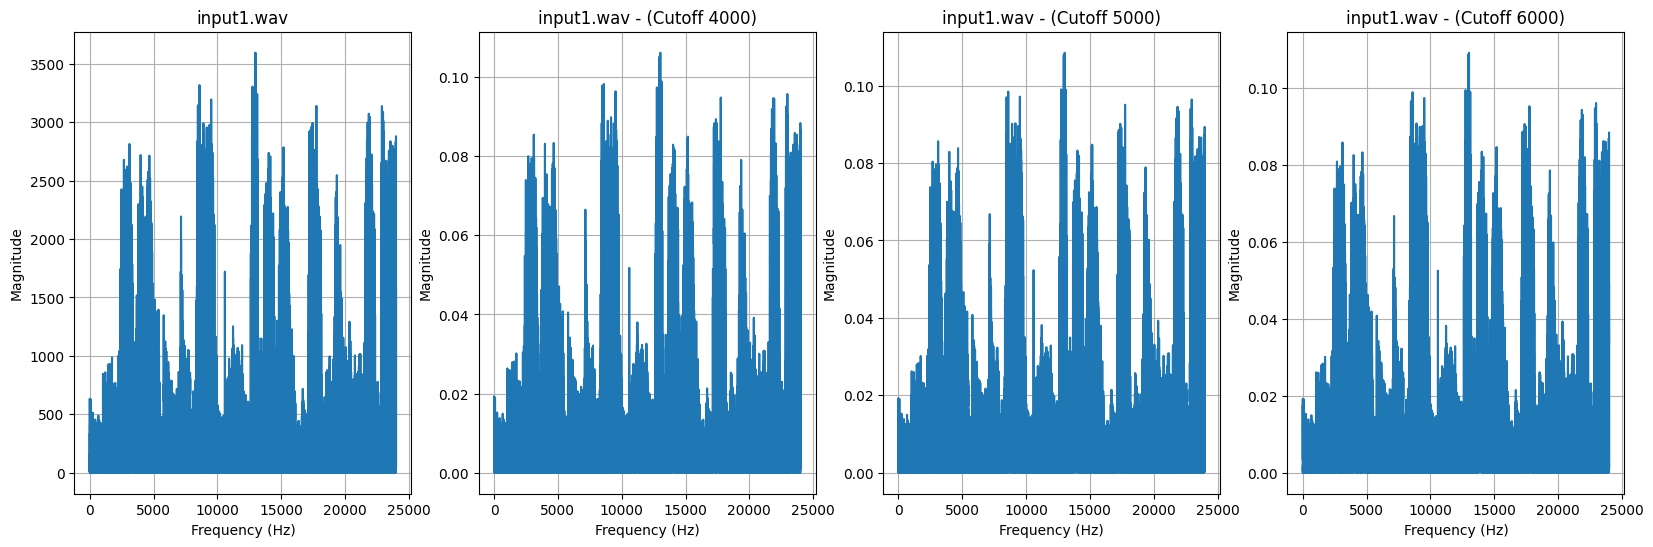

In [47]:
# Define cutoff frequencies to test
cutoff_frequencies = [4000, 5000, 6000]  # Hz
    
input_file = 'input1.wav'

filtered_audio = []

for cutoff in cutoff_frequencies:
    print(f"Processing with cutoff frequency: {cutoff} Hz")

    # Apply filter
    result, audio = filter_audio_file(input_file, cutoff)

    filtered_audio.append(result)
    
    # Save filtered signal
    output_file = f"filtered_{cutoff}_{input_file}"
    write(output_file, audio.rate, (result * 32767).astype(np.int16))
    print(f"Filtered audio saved as {output_file}")


# Plot before and after filtering audio
plot_magnitude_spectrum(filtered_audio, audio.data, Fs, cutoff_frequencies, f"{input_file}")


### After trying many cutoff frequencies, we can say that 6000 HZ is the best cutoff frequency for our application

In [48]:
filtered_audios = []

bandwidth = 3000
cutoff = 2 * bandwidth

for input_file in ['input1.wav', 'input2.wav', 'input3.wav']: 
    result, audio = filter_audio_file(input_file, cutoff)

    filtered_audios.append(result)


### **3) & 4) Performing SSB modulation in a FDM system & Plotting the magnitude spectrum of the modulated signal.**

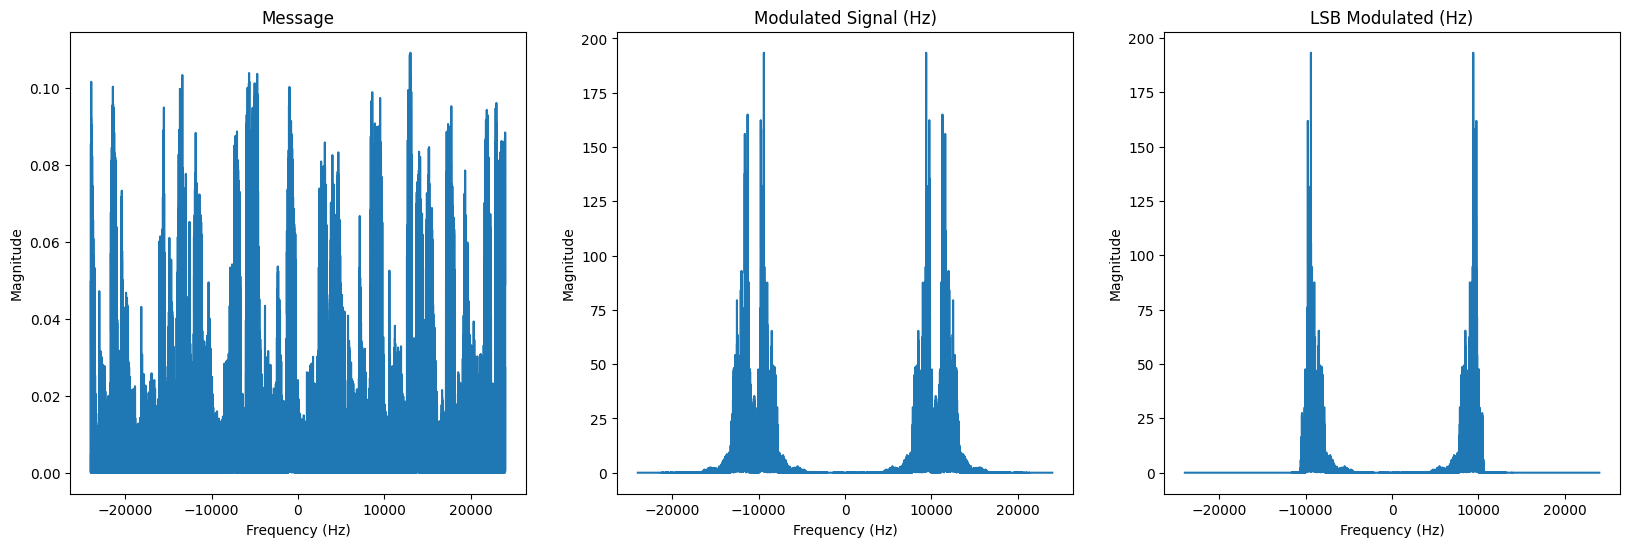

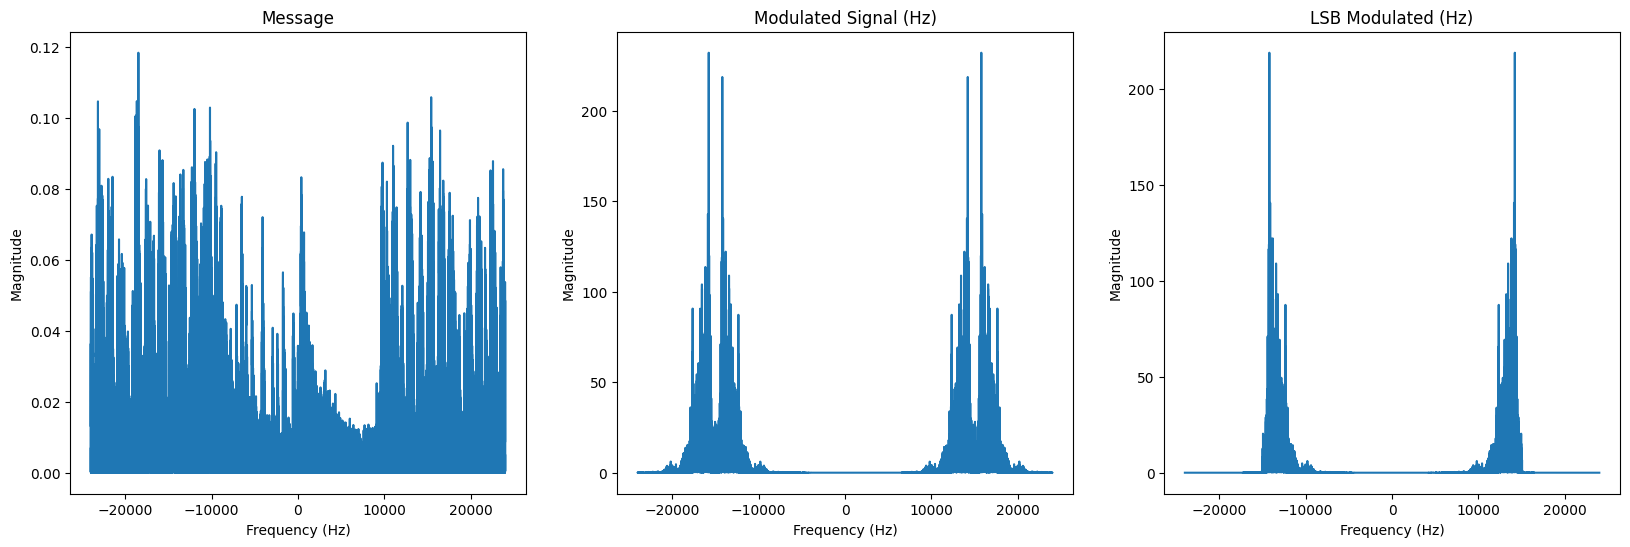

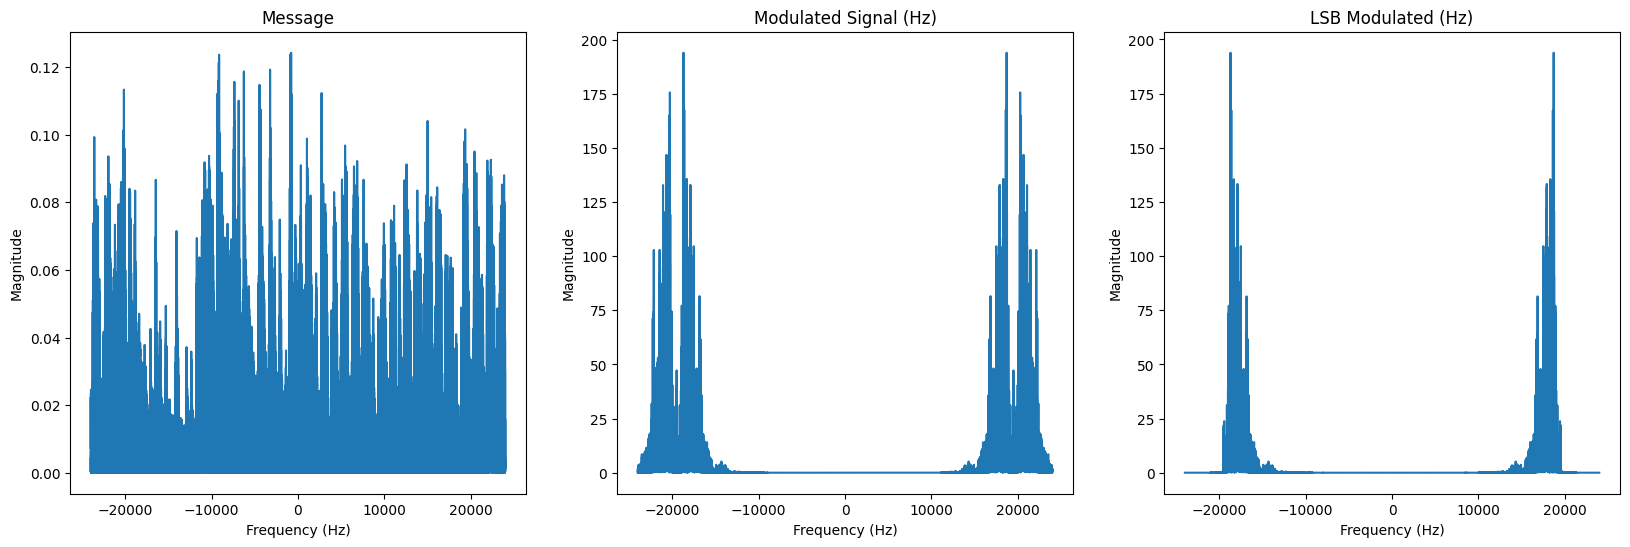

Text(0, 0.5, 'Magnitude')

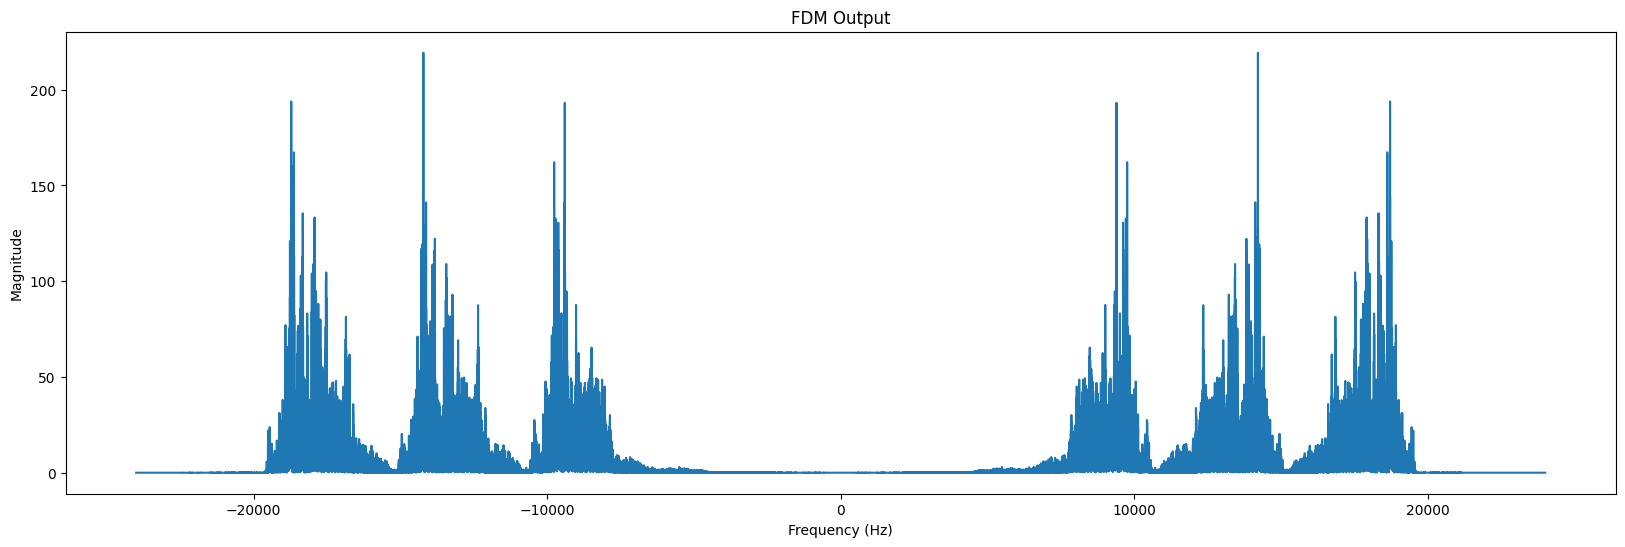

In [49]:
# SSB Moulation

t = np.linspace(0, duration, Fs * duration)
freq = np.linspace(-Fs / 2, Fs / 2, Fs * duration)

modulated_signals = []

# Design a bandpass filter to isolate the upper sideband 
def bandpass_filter(data, lowcut, highcut, fs, order=5): 
    nyquist = 0.5 * fs 
    low = lowcut / nyquist 
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band') 
    y = signal.filtfilt(b, a, data) 
    return y


final_signal = np.zeros(duration * Fs)


for index, filtered_audio in enumerate(filtered_audios):
    # initialize the carrier
    Fc = (2 + 1.5 * (index + 1)) * bandwidth
    Wc = 2 * np.pi * Fc
    carrier = np.cos(Wc * t)

    arr1 = np.array(carrier)
    arr2 = np.array(filtered_audio.reshape(-1))

    modulated_signal = (arr1) * (arr2)

    modulated_signals.append(modulated_signal)
    modulated_signal_freq = np.fft.fftshift(np.fft.fft(modulated_signal))  ## DSB


    ## Now we must get the single sideband
    filter_order = 500 
    cutoff_freq1 = 0.1 
    cutoff_freq2 = Fc 
    sample_rate = Fs
    

    # Design the bandpass filter 
    nyquist_rate = sample_rate / 2.0 
    low = cutoff_freq1 / nyquist_rate
    high = cutoff_freq2 / nyquist_rate 
    coefficients = signal.firwin(filter_order + 1, [low, high], pass_zero=False) 

    # Apply the filter to signal 
    ssb_signal = signal.lfilter(coefficients, 1.0, modulated_signal)
    ssb_signal_freq = np.fft.fftshift(np.fft.fft(ssb_signal))


    final_signal = final_signal + ssb_signal


    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)

    plt.plot(freq, abs(np.fft.fftshift(np.fft.fft(filtered_audio))))
    plt.title("Message")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

    plt.subplot(1, 3, 2)
    plt.plot(freq, abs(modulated_signal_freq))
    plt.title("Modulated Signal (Hz)")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

    plt.subplot(1, 3, 3)
    plt.plot(freq, abs(ssb_signal_freq))
    plt.title("LSB Modulated (Hz)")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

    plt.show()


plt.figure(figsize=(20, 6))
plt.subplot(1, 1, 1)

plt.plot(freq, abs(np.fft.fftshift(np.fft.fft(final_signal))))
plt.title("FDM Output")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')




In [50]:
# SSB Demodulation
def ssb_demodulater(signal, carrier_freq, Fs, bandwidth):
    t = np.arange(len(signal)) / Fs
    demodulated_signal = signal * np.cos(2 * np.pi * carrier_freq * t)
    
    # TODO:low pass filter should be implemented
    return lowpass_filter(demodulated_signal, bandwidth, Fs)